In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from torchsummary import summary
import PIL

# Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
def image_data(root_dir, augmentations=None, batch_size=1, shuffle=False):
    """
    Args:
        root_dir (string): path to the class folders
        augmentations (callable, optional): transformations to randomly apply to images, default is None
        batch_size (int): number of images in each batch, default is 1
        shuffle (bool): to shuffle the dataset or not, default is false
    Returns:
        A batched labeled image dataloader from the root_dir with applied augmentations.
    """
    if augmentations is None:
        data_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), ((255, 255, 255))),
            transforms.Normalize((0.485, 0.456, 0.406), ((0.229, 0.224, 0.225)))

        ])
    else:
        data_transform = augmentations

    dataset = datasets.ImageFolder(root=root_dir,
                                    transform=data_transform)
    data_loader = DataLoader(dataset, 
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=4)
    return data_loader



In [3]:
augment = transforms.Compose([
    transforms.RandomResizedCrop(size=(48, 64), scale=(0.8, 1.0), ratio=(1, 1)),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    # rescale to be in (0, 1)
    transforms.Normalize((0, 0, 0), ((255, 255, 255)))
])
train = image_data("IMGS/IR/train", batch_size=32, shuffle=True)
valid = image_data("IMGS/IR/valid", batch_size=32)

In [4]:
def view_img_batch(data_loader):
    plt.figure(figsize=(10,10))
    #data = iter(data_loader)
    for batch in data_loader:
        img_batch, label_batch = batch
        for i, img in enumerate(img_batch):
            # channels last
            img = img.permute(1, 2, 0)
            label = label_batch[i]
            plt.subplot(3, 3, i+1)
            plt.imshow(img.numpy())
            plt.title(label.numpy())
            plt.axis('off')
            if i == 8:
                plt.show()
                break
        break
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


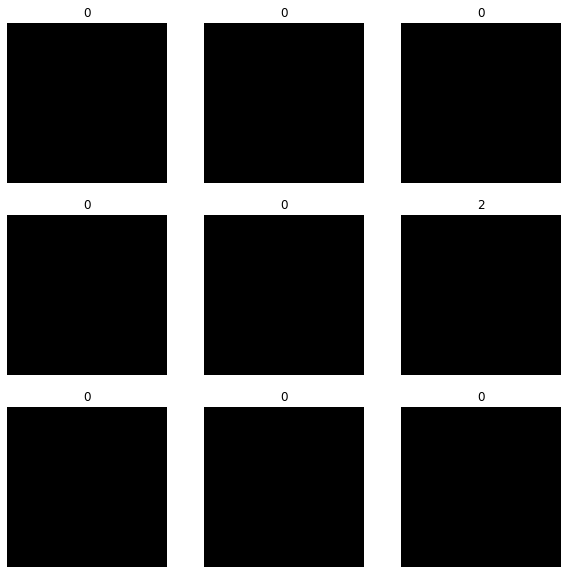

In [78]:
view_img_batch(train)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True).train(mode=False)
        self.fc1 = nn.Linear(1000, 3)
        

    def forward(self, x):
        x = self.model(x)
        x = self.fc1(x)
        x = F.softmax(x)
        return x

In [6]:
net = Net()
summary(net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

(tensor(3504872), tensor(3504872))

In [7]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("Starting training...")
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward, backward + optimize
        outputs = net(inputs)
        #print(np.shape(outputs), np.shape(labels))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        if i % 2 == 1:  # print every 2 mini-batches
            print('Epoch %d :\tTraining loss : %.3f' % 
                    (epoch + 1, running_loss / 2))
            running_loss = 0.0

print("Finished Training")


Starting training...
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epoch 1 :	Training loss : 6.730
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epoch 1 :	Training loss : 6.517
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epoch 1 :	Training loss : 6.304
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epoch 1 :	Training loss : 6.359
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epoch 1 :	Training loss : 6.348
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epoch 1 :	Training loss : 6.233
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epoch 1 :	Training loss : 6.167
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epoch 1 :	Training loss : 6.035
torch.Size([32, 1000]) torch.Size([32])
torch.Size([32, 1000]) torch.Size([32])
Epo

In [50]:
# Validation
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in valid:
        imgs, labels = data
        outputs = net(imgs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(150):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

classes = ('nonbreaking', 'plunge', 'spill')

for i in range(3):
    print("Accuracy of %5s : %2d %%" % (
        classes[i], 100*class_correct[i]/class_total[i]))

TypeError: eval() takes 1 positional argument but 2 were given

In [ ]:
def validation_report(model, valid, VAL_BATCH_SIZE, STEP_SIZE_VALID):
    print("\ngenerating validation report...")
    pred = np.array()
    la = np.array()
    for data in valid:
        imgs, labels = data
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        np.append(pred, c)
        np.append(la, labels)
    #p = model.predict(valid_data, steps=STEP_SIZE_VALID)
    #preds = np.zeros_like(p)
    #preds[np.arange(len(p)), p.argmax(1)] = 1
    #labels = np.zeros_like(preds)
    for i in range(STEP_SIZE_VALID):
        _, labelBatch = next(valid_data)
        labels[i*VAL_BATCH_SIZE: (i+1)*VAL_BATCH_SIZE] = labelBatch
    print(classification_report(labels, preds))


In [30]:
label.squeeze()

tensor(2)